In [231]:
import pandas as pd
import numpy as np 
import pathlib
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import TimeDistributed
from keras.optimizers import Adam

In [232]:
# Loading the dataset 
data_dir = pathlib.Path('/home/lv11/Documents/ProyectosPython/sentimentAnalysis/train')
nf = pd.read_csv(data_dir / 'tweetsDataset1.csv',skiprows=1,names=['Message','Target'])
#print(nf.head(20))


In [233]:
nlp = English()
stop_words = list(STOP_WORDS)

messages = nf['Message']
labels = nf['Target']
#print(stop_words)

def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuation ]
    return tokens

In [234]:
def vectorization(tweets):
    vector = CountVectorizer(tokenizer=spacy_tokenizer)
    frequency_matrix = vector.fit_transform(tweets)
    sum_frequencies = np.sum(frequency_matrix,axis=0)
    frequency = np.squeeze(np.asarray(sum_frequencies))
    frequency_dataFrame = pd.DataFrame([frequency],columns=vector.get_feature_names()).transpose()
    return frequency_dataFrame

In [235]:
def splitting(messages,labels):
    X_train,X_test,y_train,y_test = train_test_split(messages,labels,test_size=0.25,random_state=42,shuffle=True)
    return X_train,X_test,y_train,y_test

In [236]:
def tokenization_tweets(dataset,features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

In [237]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon,decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    history = model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=True)
    return model_nn, history

In [238]:
def test(X_test,model):
    predict = model.predict(X_test)
    return predict

In [239]:
def modelo1(X_train,y_train):
    features = 1554 #3199 1554 1727 # puede ser 3727 o un valor asi que vi como len() del array de X_train 
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train,features)
    modelo, history = train(X_train_mod, y_train,features,shuffle,drop,layer1,layer2,epoch,lr,epsilon,validation)
    return modelo, history

In [240]:
frequency_dataFrame = vectorization(messages)

In [241]:
X_train,X_test,y_train,y_test = splitting(messages,labels)

In [242]:
modelo, history = modelo1(X_train,y_train)

Train on 1554 samples, validate on 173 samples
Epoch 1/10
1554/1554 [==============================] - 1s 962us/step - loss: 0.6666 - accuracy: 0.6203 - val_loss: 0.3074 - val_accuracy: 0.9017
Epoch 2/10
1554/1554 [==============================] - 1s 836us/step - loss: 0.2358 - accuracy: 0.9035 - val_loss: 0.2140 - val_accuracy: 0.9017
Epoch 3/10
1554/1554 [==============================] - 1s 926us/step - loss: 0.1065 - accuracy: 0.9582 - val_loss: 0.3220 - val_accuracy: 0.8613
Epoch 4/10
1554/1554 [==============================] - 2s 983us/step - loss: 0.0680 - accuracy: 0.9768 - val_loss: 0.3399 - val_accuracy: 0.8555
Epoch 5/10
1554/1554 [==============================] - 2s 1ms/step - loss: 0.0512 - accuracy: 0.9807 - val_loss: 0.4254 - val_accuracy: 0.8324
Epoch 6/10
1554/1554 [==============================] - 2s 1ms/step - loss: 0.0341 - accuracy: 0.9884 - val_loss: 0.4297 - val_accuracy: 0.8497
Epoch 7/10
1554/1554 [==============================] - 2s 1ms/step - loss: 0.026

In [243]:
modelo.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               796160    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 771       
Total params: 928,259
Trainable params: 928,259
Non-trainable params: 0
_________________________________________________________________


In [244]:
input_data = tokenization_tweets(X_test,1554) #1554
#input_data

In [245]:
pred = modelo.predict(input_data)
#X_test

In [246]:
xtest = [x for x in X_test]
for i in range(len(pred)):
    sent = (1 if pred[i][1] >0.5 else 0)
    print("tweet = %s, sentiment = %s" % (xtest[i],sent))

eet = The most painful goodbyes are the onesthat are never said and never explained crying  unhappy  :/, sentiment = 1
tweet =  wifi, sentiment = 0
tweet = Just win at weekend and it will be a late gift, sentiment = 1
tweet =  I'm aborting mission now have a nice day though x , sentiment = 0
tweet = Be happy, sentiment = 1
tweet =  w, sentiment = 1
tweet = YG should have sent them to MCD. I want to see them holding the trophy unhappy  anyways .9, sentiment = 0
tweet =  idea of saying No to almo, sentiment = 1
tweet = I can't do it all on my own. (See what I did there? ) .1, sentiment = 0
tweet = I dedicate this song to, sentiment = 1
tweet = wish knock out lang talaga for the new school year are good and cooperative groupmates please unhappy , sentiment = 0
tweet =  you change your whole life happy, sentiment = 0
tweet = CAN SOMEONE PLS GIFT ME XAYAH USING PI PLSSSS? unhappy , sentiment = 1
tweet = Don't be buffalo unhappy , sentiment = 1
tweet = I check Beautiful News every single day

In [247]:
i = 0
for y in y_test:
    print(xtest[i]," ---> ",y)
    i = i+1

 a new video about game genres.RTs are super appreciated happy  --->  1
Episode two now crying with joy  --->  1
I hope it was great   --->  0
thanks for the recent follow.3  --->  1
One table last night told me I look like a graceful ballerina gliding through tables- then another told me I looked like a flash dancer unhappy   --->  0
to  pork pies happy  --->  1
Hellooo.. happy  satans-daughter (taylynnox)  --->  1
When your online crush comes to the meet-up without their Snapchat filter unhappy    --->  0
Hi instant message your friend  friend lang  --->  0
Wth why did 4/20 have to happen during the Easter holidays it's one of the best days in Leeds unhappy   --->  0
this is jimin to yoongi unhappy  .6  --->  0
 Thank you happy  --->  1
 and still not being rich - try getting a life  --->  1
April is really really bloody. I'm so proud of our boys crying with joy  --->  1
Wow i just made a JS compressor that actually checks scoped variables existing. Turns out i have a few issues happ

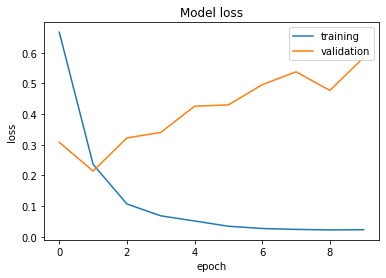

In [248]:
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper right')
plt.show()

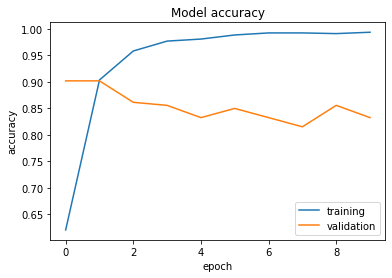

In [249]:
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [250]:
test_loss,test_acc = modelo.evaluate(input_data,y_test)

576/576 [==============================] - 0s 172us/step


In [251]:
print("test loss:", test_loss)
print("test accuracy:",test_acc)

test loss: 2.18272907866372
test accuracy: 0.5277777910232544
